# Racetrack
A simple extension of our last exploration into [gridworld](https://github.com/laxatives/rl/blob/master/gridworld_mdp.ipynb).

Here we extend exercise 5.12 in [Sutton & Barto](http://incompleteideas.net/book/the-book-2nd.html), shown below, to consider Temporal Difference Learning. We also choose to remove some of the velocity constraints imposed in the description below.

Our agent should learn the mechanics of maintaining a *racing line*, starting turns wide before committing to an apex to maximize speed out of the turn and minimize the total time spent navigating our "gridworld".

<img src="images/racetrack.png" width="85%" />
<img src="images/racetrack2.png" width="85%" />

In [74]:
from __future__ import print_function
from IPython.display import display
from pandas.plotting import register_matplotlib_converters

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random


pd.options.display.max_columns = None
register_matplotlib_converters()

%matplotlib inline

## The Action-Space
Driver can accelerate, coast, or decelerate in both X-Y axes.

In [75]:
from enum import Enum


MAX_VELOCITY = 5


class ActionX(Enum):
    """+X is East"""
    ACCEL = 'AX', 0, lambda x,y: (min(x + 1, MAX_VELOCITY), y), (1, 0)
    STEADY = 'SX', 1, lambda x,y: (x, y), (0, 0)
    DECEL = 'DX', 2, lambda x,y: (max(x - 1, -MAX_VELOCITY), y), (-1, 0)
    def __init__(self, display_name, index, transition, unit_vector):
        self.display_name = display_name
        self.index = index
        self.transition = transition  # matplotlib coordinates
        self.unit_vector = unit_vector  # matplotlib coordinates
        
    def __str__(self):
        return self.display_name
    
    
class ActionY(Enum):
    """+Y is North"""
    ACCEL = 'AY', 0, lambda x,y: (x, min(y + 1, MAX_VELOCITY)), (0, 1)
    STEADY = 'SY', 1, lambda x,y: (x, y), (0, 0)
    DECEL = 'DY', 2, lambda x,y: (x, max(y - 1, -MAX_VELOCITY)), (0, -1)
    def __init__(self, display_name, index, transition, unit_vector):
        self.display_name = display_name
        self.index = index
        self.transition = transition  # matplotlib coordinates
        self.unit_vector = unit_vector  # matplotlib coordinates
        
    def __str__(self):
        return self.display_name    

## The Grid

In [76]:
from itertools import product


class Track(object):
    def __init__(self, coords, color_range=None):
        # Everything is in matplotlib coordinates now (origin is bottom-left)
        # Let's never think about row-major ever again and pretend it never happened in the first-place
        self.coords = np.rot90(coords, 3)
        
        # Assumes start from bottom row
        self.starts = list(product([x for x, val in enumerate(coords[-1]) if val > 0], [0]))
        
        # Assumes right handed turn ending in North East corner
        end_y = set([i for i, val in enumerate(self.coords[-1]) if val > 0])
        self.is_end = lambda x,y: y in end_y and x >= coords.shape[1] - 1
        
        # Plotting Parameters
        self.color_range=color_range
        
    def is_valid_position(self, x, y):
        return self.coords[(x, y)] > 0


In [77]:
track_a_coords = np.array([
    [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
])

TRACK_A = Track(track_a_coords, color_range=(-10, 0))

In [78]:
track_b_coords = np.array([
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],     
    [0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],     
    [0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1], 
    [0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1], 
    [0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1], 
    [0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1], 
    [0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1], 
    [0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1], 
    [0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1], 
    [0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],     
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0], 
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0], 
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0], 
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0], 
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0],     
    [0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0],    
    [0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0],    
    [0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0],    
    [0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0],    
    [0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0],   
    [0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0],     
    [0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0],     
    [0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0],     
    [0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0],     
    [0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0],     
    [0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0],     
    [0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0],    
    [0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0],    
    [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0],
    [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0],    
    [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0],
])

TRACK_B = Track(track_b_coords, color_range=(-20, 0))

In [79]:
import matplotlib.lines as mlines
from itertools import product


def fill_square(x, y, ax, color, alpha=1.0):    
    square_x = [x, x, x+1, x+1]
    square_y = [y, y+1, y+1, y]
    ax.fill(square_x, square_y, color, alpha=alpha)


def plot_track(track, state=None, action=None, title='Race Track', padding=1, offset=0, alpha=0.5):    
    fig, ax = plt.subplots(figsize=(5, 4))    
    if title:
        ax.set_title(title)
    ax.set_xlim(-padding + offset, track.coords.shape[0] + padding + offset)
    ax.set_ylim(-padding + offset, track.coords.shape[1] + padding + offset)

    for x_ind, y_ind in product(range(-padding, track.coords.shape[0] + padding), 
                                range(-padding, track.coords.shape[1] + padding)):
        x, y = x_ind + offset, y_ind + offset
        if (0 <= x_ind < track.coords.shape[0] and 
                0 <= y_ind < track.coords.shape[1] and 
                track.coords[(x_ind, y_ind)] > 0):
            ax.add_line(mlines.Line2D([x,x+1], [y,y], color='k', linewidth=0.5))
            ax.add_line(mlines.Line2D([x,x], [y,y+1], color='k', linewidth=0.5))
            ax.add_line(mlines.Line2D([x+1,x+1], [y,y+1], color='k', linewidth=0.5))
            ax.add_line(mlines.Line2D([x,x+1], [y+1,y+1], color='k', linewidth=0.5))        
            
        if track.is_end(x_ind, y_ind):
            fill_square(x, y, ax, 'g', alpha=alpha)            
            
    for x_ind, y_ind in track.starts:
        x, y = x_ind + offset, y_ind + offset
        fill_square(x, y, ax, 'r', alpha=alpha)
        
    if state:
        x, y = state.position
        x += offset
        y += offset
        fill_square(x, y, ax, 'b', alpha=0.9)
        dx, dy = state.velocity
        
        # Plot after-state instead of current state if action is available
        if action:
            aX, aY = Driver.itoa(action)            
            ax.arrow(x + 0.5, y + 0.5, dx + aX.unit_vector[0], dy + aY.unit_vector[1], head_width=0.5)
        else:
            ax.arrow(x + 0.5, y + 0.5, dx, dy, head_width=0.5)
        
    return fig, ax

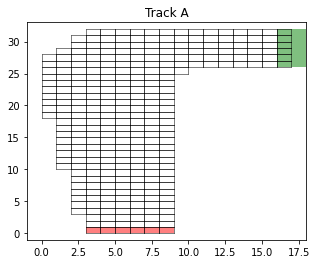

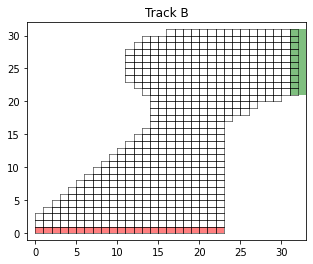

In [80]:
_ = plot_track(TRACK_A, title='Track A')
_ = plot_track(TRACK_B, title='Track B')
# TODO: chicane, import Circuit de Monaco

## The Environment

In [81]:
class DriverState(object):
    def __init__(self, position, velocity=(0, 0), terminal=False):
        self.position = position
        self.velocity = velocity
        self.terminal = terminal
        
    def __str__(self):
        s = f'x=({self.position[0]},{self.position[1]}),v=({self.velocity[0]},{self.velocity[1]})'
        if self.terminal:
            s += ',TERMINAL'
        return s
    

class Drive(object):
    def __init__(self, track, slippage=0):
        self.track = track
        self.state = DriverState(random.choice(track.starts))
        self.slippage = slippage
        
    def set_state(self, state):
        self.state = state
        
    def _transition_state(self, ax, ay):
        """Try to apply the ACTION and check whether it is valid."""
        x, y = self.state.position
        vx, vy = self.state.velocity
        new_vx, new_vy = ay.transition(*ax.transition(vx, vy))
        
        # Tire slippage in X
        if random.random() < self.slippage:
            new_vx = vx
            
        # Tire slippage in Y
        if random.random() < self.slippage:
            new_vy = vy
            
        new_x, new_y = x + new_vx, y + new_vy
        
        terminal = False
        if self.track.is_end(new_x, new_y):
            # Terminal state, episode ends
            terminal = True
        elif (new_x < 0 or new_x >= self.track.coords.shape[0] or 
              new_y < 0 or new_y >= self.track.coords.shape[1] or 
              not self.track.is_valid_position(new_x, new_y)):
            # CRASH
            return None
        return DriverState((new_x, new_y), (new_vx, new_vy), terminal=terminal)
    
    def transition(self, ax, ay):
        """Apply the given ACTION to the current state and return the new state and reward."""
        reward = -1
        new_state = self._transition_state(ax, ay)

        if new_state is None:
            # CRASH
            new_state = DriverState(random.choice(self.track.starts))
        elif new_state.terminal:
            # End of episode
            reward = 0           

        self.state = new_state
        return self.state, reward   
    
    def plot(self, action=None):
        plot_track(self.track, self.state, action=action)

## The Agent

In [97]:
class Driver(object):
    """Learn the Optimal Policy beginning with a random policy and no priors."""    
    def __init__(self, track, name='Learned', epsilon=0):
        self.action_values = np.zeros((track.coords.shape[0],  # state: x
                                       track.coords.shape[1],  # state: y
                                       2 * MAX_VELOCITY + 1,   # state: vx
                                       2 * MAX_VELOCITY + 1,   # state: vy
                                       len(ActionX) * len(ActionY)))
        self._policy = np.random.randint(0, 9, 
                                         (track.coords.shape[0],
                                          track.coords.shape[1],
                                          2 * MAX_VELOCITY + 1,
                                          2 * MAX_VELOCITY + 1))
        self.track = track        
        self.name = name
        self.epsilon = epsilon
        
    @staticmethod
    def itoa(i):
        """Int to Action"""
        if i < 0 or i > 8:
            raise RuntimeError(i)          
            
        ax = ActionX.STEADY
        vx = i % 3
        if vx == 0:
            ax = ActionX.ACCEL
        elif vx == 2:
            ax = ActionX.DECEL
            
        ay = ActionY.STEADY
        vy = i // 3
        if vy == 0:
            ay = ActionY.ACCEL
        elif vy == 2:
            ay = ActionY.DECEL
            
        return ax, ay
        
        
    def policy(self, state, explore=True):
        if explore and random.random() < self.epsilon:
            i = np.random.randint(0, 9)
        else:
            i = self._policy[state]
        return i
    
    def update_state_policy(self, s):
        old_i = self._policy[s]
        new_i = np.argmax(self.action_values[s])
        
        # Not stable
        if new_i != old_i:
            self._policy[s] = new_i
            return False
        
        # Stable
        return True     
    
    def policy_improvement(self):
        """Update our policy based on our latest action_values"""
        policy_stable = True
        for s, _ in np.ndenumerate(self._policy):
            stable = self.update_state_policy(s)
            if not stable:
                policy_stable = False
            
        return policy_stable
    
    def plot_action_values(self, state=None, action=None, title=None, padding=1,
                           save_path=None, value_alpha=0.2):
        """
        Display a colormap using the highest explored outcome for each position, 
        or the mean value if no state in the position has been observed
        """
        if title == None:
            title = f'{self.name}: Mean Action Values'
        fig, ax = plot_track(self.track, state=state, action=action,
                             title=title, padding=padding, offset=0.5, alpha=value_alpha)
        mean_action_values = np.zeros((self.action_values.shape[0] + 2*padding, 
                                       self.action_values.shape[1] + 2*padding))
        for x, y in product(range(self.action_values.shape[0]), range(self.action_values.shape[1])):
            q = self.action_values[(x, y)]
            explored = q[np.nonzero(q)]
            display_val = 0  # Default: 0 (white)
            if explored.size > 0:  # Position has observations: plot the optimistic estimate
                display_val = np.max(explored)
            elif self.track.is_valid_position(x, y):  # Unexplored position: plot the mean
                display_val = np.mean(self.action_values)
            mean_action_values[(x + padding, y + padding)] = display_val
                
        vmin = self.track.color_range[0] if self.track.color_range else None
        vmax = self.track.color_range[1] if self.track.color_range else None
        im = ax.imshow(mean_action_values.T, cmap='hot', alpha=0.9, vmin=vmin, vmax=vmax)
        fig.colorbar(im, ax=ax)
        if save_path:
            plt.savefig(f'{save_path}/{title}.png')
        
    # TODO: plot policy

## The Algorithm: Monte Carlo
Unlike Value Iteration and Linear Programming, Monte Carlo allows us to focus on samples that are relevant. We target episodes beginning from the starting the line and can avoid training in the many invalid states outside of our track as well as unusual states, such as driving in reverse near the finish line.

In [138]:
# TODO: parallellize
def mc_control(drive, agent=None, every_visit=True, gamma=0.9, epsilon=0.1,
               T=int(1e5), iterations=int(1e4), iterations_start=0, log_frequency=None):
    if log_frequency is None:
        log_frequency = iterations // 5 if iterations > 10 else iterations + 1

    if agent is None:
        agent = Driver(drive.track, name='Max Verstappen', epsilon=epsilon)
    mean_return = np.zeros((drive.track.coords.shape[0],  # state: x
                            drive.track.coords.shape[1],  # state: y
                            2 * MAX_VELOCITY + 1,         # state: vx
                            2 * MAX_VELOCITY + 1,         # state: vy
                            len(ActionX) * len(ActionY)))
    return_count = np.zeros((drive.track.coords.shape[0],  # state: x
                             drive.track.coords.shape[1],  # state: y
                             2 * MAX_VELOCITY + 1,         # state: vx
                             2 * MAX_VELOCITY + 1,         # state: vy
                             len(ActionX) * len(ActionY)))    
    for i in range(iterations_start, iterations + 1):
        title=f'MC Control: Iteration {i:05d}'
        if i % log_frequency == 0:
            print(f'\tIteration {i} of {iterations}...')
            agent.plot_action_values(title=title)

        # Simulate episode from random (state, action)
        x0, y0 = random.choice(drive.track.starts)
        vx0, vy0 = (0, 0) 
        drive.set_state(DriverState(position=(x0, y0), velocity=(vx0, vy0)))                                                                             
        s0 = (x0, y0, vx0, vy0)  # position_x, position_y, velocity_x, velocity_y
        episode = [s0]  # s0, a0, s1, r1, a1, s2, r2, a2, s3...
                        
        a0 = np.random.randint(0, 8)
        steps = 0
        terminated = False
        while steps < T:
            state, r1 = drive.transition(*Driver.itoa(a0))
            s1 = (state.position[0], state.position[1], state.velocity[0], state.velocity[1])
            episode.extend([a0, s1, r1]) 
            if r1 >= 0:  # terminal state
                terminated = True
                break
            a0 = agent.policy(s1)
            steps += 1
            
        if not terminated:
            continue

        # Replay backwards from the end of the episode
        ret = 0
        j = steps - 1
        episode_returns = {}
        while j > 0:
            r1 = episode[3*j + 3]
            a0 = episode[3*j + 1]
            s0 = episode[3*j - 1]
            j -= 1

            ret = r1 + gamma * ret
            key = (s0[0], s0[1], s0[2], s0[3], a0)
            episode_returns[key] = ret
            if every_visit:
                mean_ret = mean_return[key]
                c = return_count[key]
                mean_return[key] = (mean_ret * c + ret) / (c + 1)
                return_count[key] = c + 1

        # Update action values q(s,a)
        for key, ret in episode_returns.items():
            if not every_visit:
                mean_ret = mean_return[key]
                c = return_count[key]
                mean_return[key] = (mean_ret * c + ret) / (c + 1)
                return_count[key] = c + 1
            agent.action_values[key] = mean_return[key]

        # Update policy
        agent.policy_improvement()
    return agent

### Learning the circuit

	Iteration 2000 of 10000...


KeyboardInterrupt: 

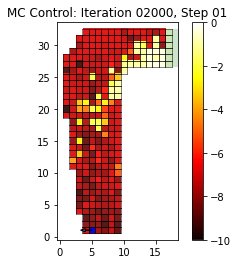

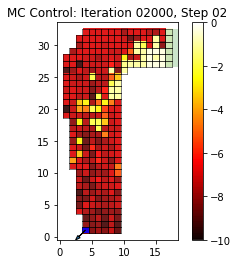

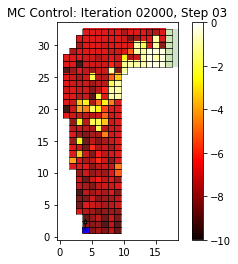

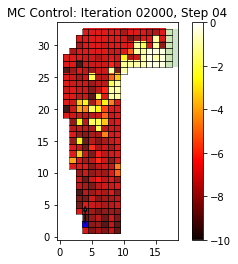

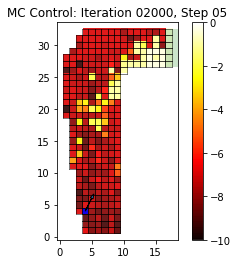

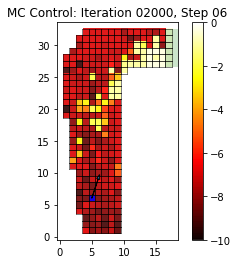

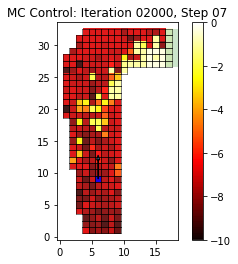

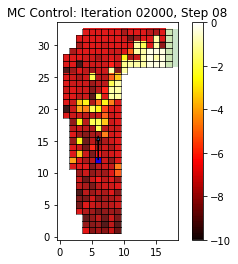

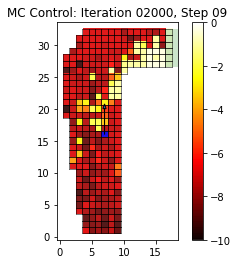

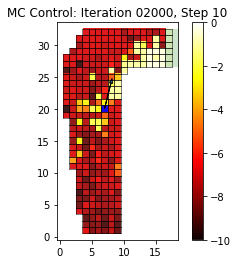

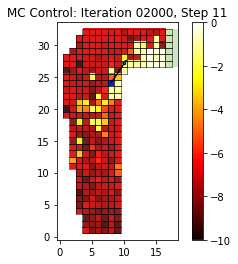

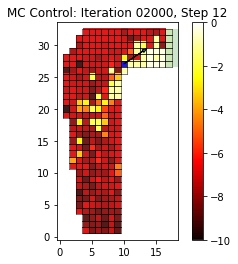

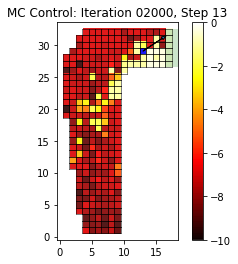

In [103]:
# Train Max Verstappen at Spa-Francorchamps
a = mc_control(Drive(TRACK_A))
a.plot_action_values(title=f'MC Control: Track A')

### The Test

In [ ]:
def test_drive(track, driver, max_steps=16, title=None, save_path=None):
    if not title:
        title = 'Test'
    
    environment = Drive(track)
    
    i = 0
    r = -1
    state = environment.state
    while i < max_steps and r < 0:
        s = (state.position[0], state.position[1], state.velocity[0], state.velocity[1])
        a = driver.policy(s, explore=False)    
        
        driver.plot_action_values(state=state, action=a, title=f'{title}, Step {i+1:02d}', save_path=save_path) 
        
        # Don't let Max stand still during a timed trial.... 
        old_position = state.position
        while state.position == old_position:
            state, r = environment.transition(*Driver.itoa(a))
            a = np.random.randint(0, 9)
        
        i += 1
        
    if r < 0:
        print("Max, that was embarassing.")

In [ ]:
# Time Trial Max Verstappen
test_drive(TRACK_A, a)

## Track B: Monaco

	Iteration 2000 of 10000...
	Iteration 4000 of 10000...
	Iteration 6000 of 10000...
	Iteration 8000 of 10000...


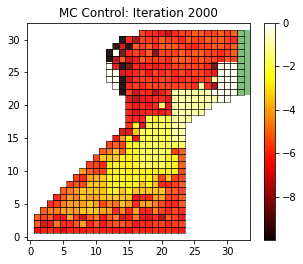

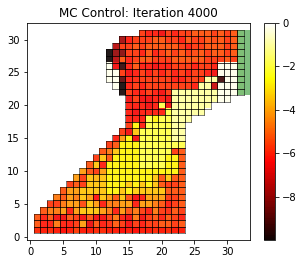

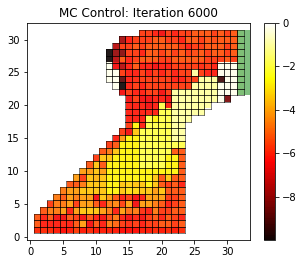

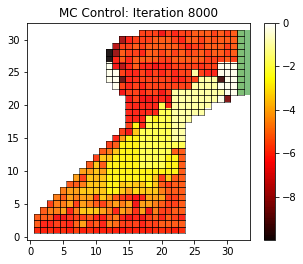

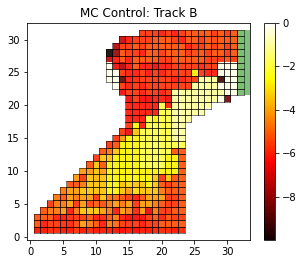

In [14]:
# Max putting in his time at Monte Carlo, Monaco
b = mc_control(Drive(TRACK_B))
b.plot_action_values(title=f'MC Control: Track B')

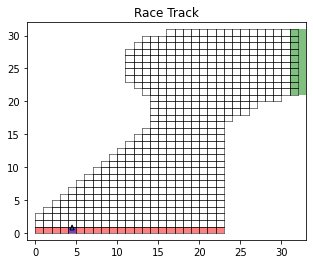

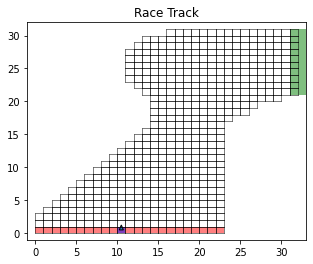

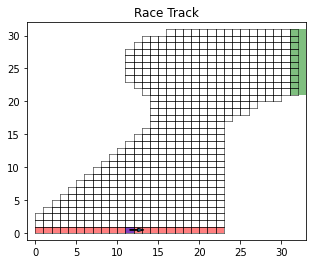

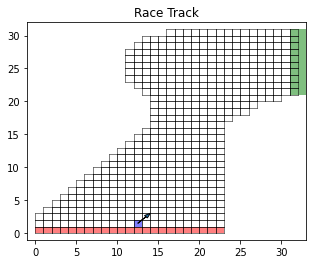

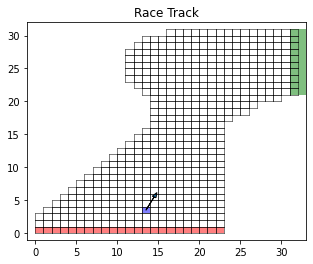

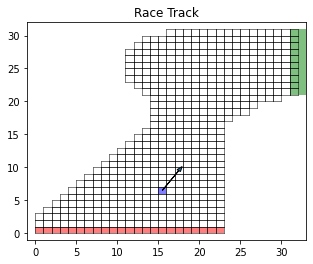

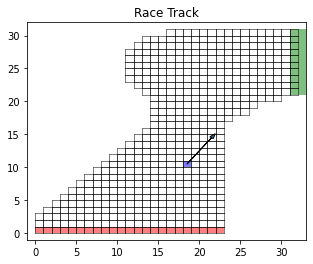

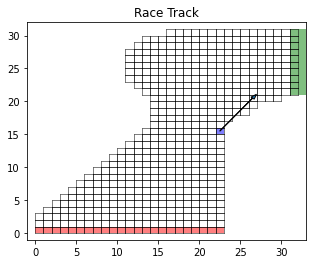

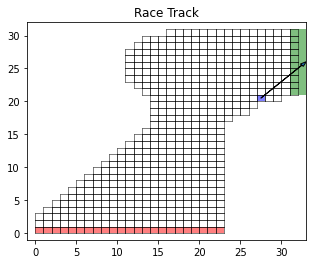

In [15]:
# Time Trial 
test_drive(TRACK_B, b)

### Specification Gaming: Max Verstappen is a dirty cheater
The driver learned that it can repeatedly crash by moving backwards from the starting line until it gets to a solved start position where it has previously successfully completed the turn.

Let's try that again after forcing Max to pay for damages each time he crashes.

In [16]:
class DriveRevised(Drive):
    def transition(self, ax, ay):
        """Apply the given ACTION to the current state and return the new state and reward."""
        reward = -1
        new_state = self._transition_state(ax, ay)

        if new_state is None:
            # CRASH
            new_state = DriverState(random.choice(self.track.starts))
            reward = -10  # The new penalty for crashing
        elif new_state.terminal:
            # End of episode
            reward = 0          

        self.state = new_state
        return self.state, reward   

### John Hunter Competition Entry
Save images to create a GIF for the 2020 [SciPy John Hunter Excellence in Plotting Competition](https://www.scipy2020.scipy.org/plotting-contest)

Iteration 0
Max, that was embarassing.


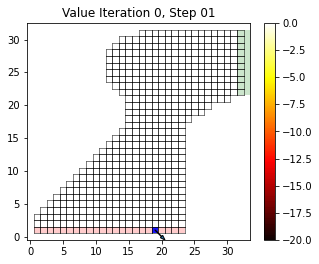

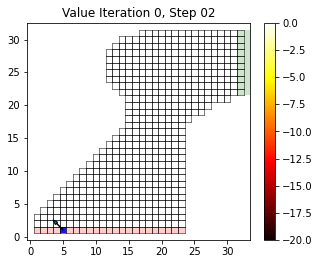

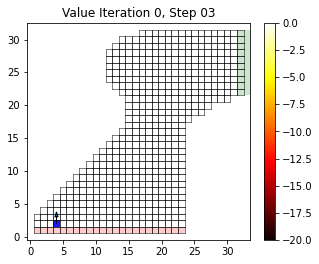

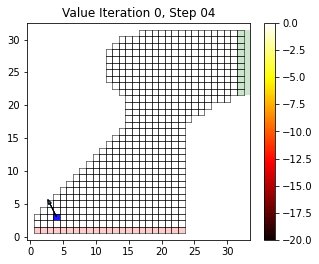

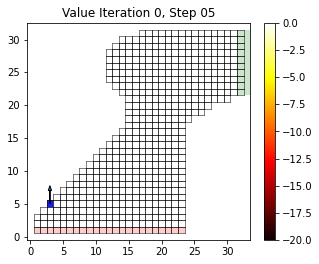

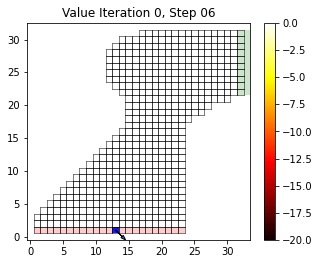

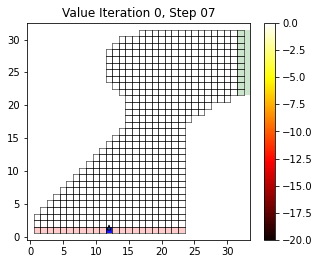

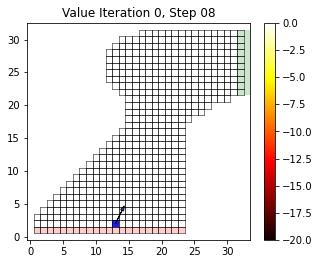

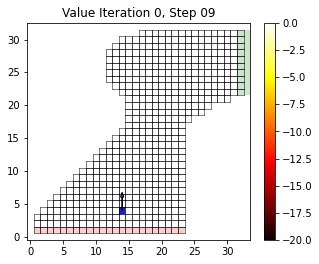

In [ ]:
jh_drive = DriveRevised(TRACK_B)
jh_iterations = 2000
save_path = f'images/john_hunter_2020'
start = 0
print(f'Iteration {start}')
b_revised = Driver(jh_drive.track, name='Max Verstappen', epsilon=0.1)
test_drive(jh_drive.track, b_revised, title=f'Value Iteration {start}', save_path=save_path)

In [ ]:
mc_control(jh_drive, agent=b_revised,
           iterations=jh_iterations, iterations_start=start, log_frequency=1000000)
start += 2000

In [ ]:
print(f'Test Iteration {start}')
test_drive(TRACK_B, b_revised, title=f'Value Iteration {start}', save_path=save_path)

In [ ]:
mc_control(DriveRevised(TRACK_B), agent=b_revised,
           iterations=jh_iterations, iterations_start=start, log_frequency=1000000)
start += 2000

In [ ]:
print(f'Test Iteration {start}')
test_drive(TRACK_B, b_revised, title=f'Value Iteration {start}', save_path=save_path)

In [ ]:
mc_control(DriveRevised(TRACK_B), agent=b_revised,
           iterations=jh_iterations, iterations_start=start, log_frequency=1000000)
start += 2000

In [ ]:
print(f'Test Iteration {start}')
test_drive(TRACK_B, b_revised, title=f'Value Iteration {start}', save_path=save_path)

In [ ]:
mc_control(DriveRevised(TRACK_B), agent=b_revised,
           iterations=jh_iterations, iterations_start=start, log_frequency=1000000)
start += 2000

In [ ]:
print(f'Test Iteration {start}')
test_drive(TRACK_B, b_revised, title=f'Value Iteration {start}', save_path=save_path)

In [ ]:
mc_control(DriveRevised(TRACK_B), agent=b_revised,
           iterations=jh_iterations, iterations_start=start, log_frequency=1000000)
start += 2000

In [ ]:
print(f'Test Iteration {start}')
test_drive(TRACK_B, b_revised, title=f'Value Iteration {start}', save_path=save_path)

	Iteration 0 of 10000...
Max, that was embarassing.
	Iteration 2000 of 10000...


/code/venvs/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if sys.path[0] == '':


Max, that was embarassing.


KeyboardInterrupt: 

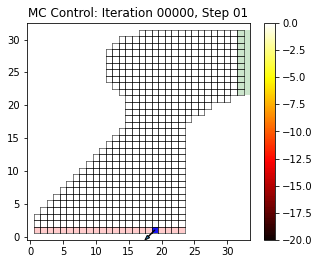

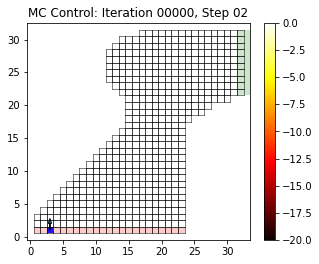

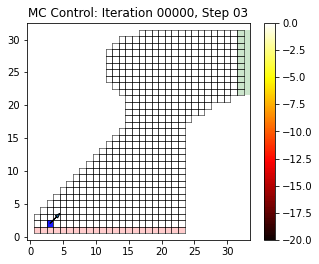

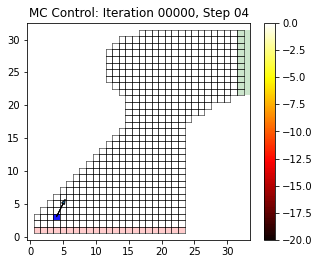

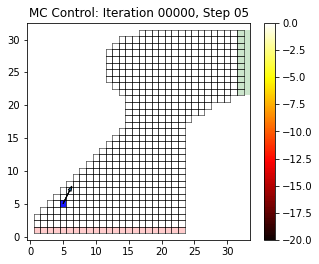

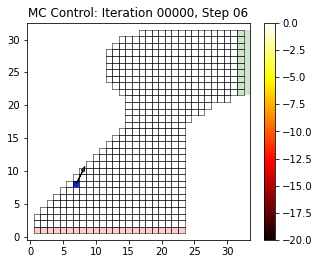

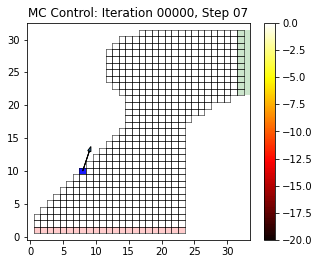

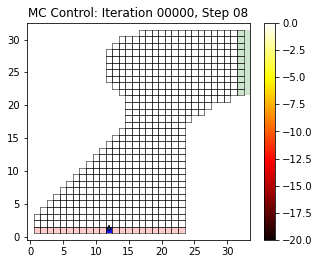

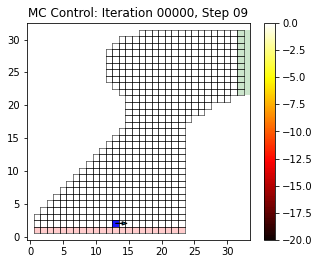

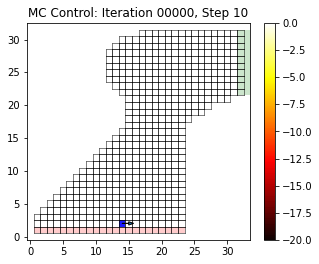

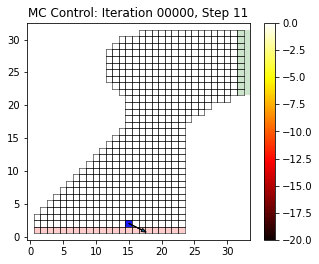

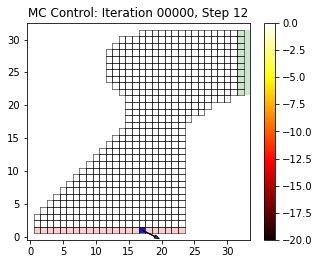

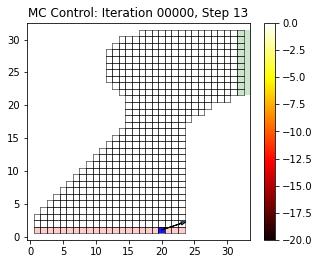

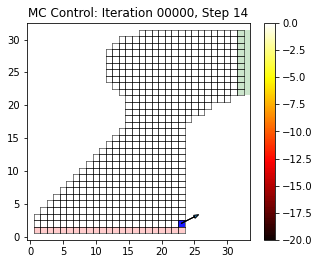

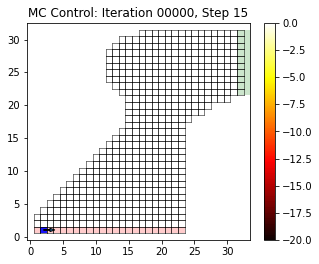

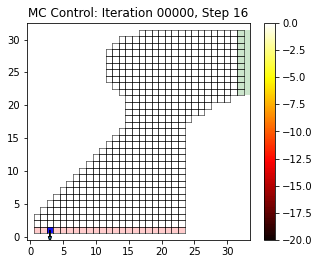

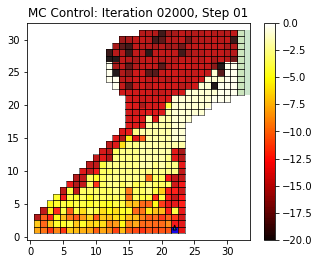

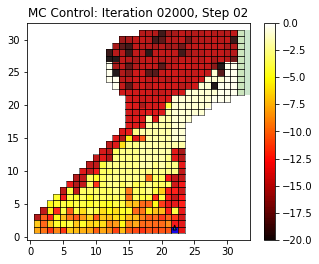

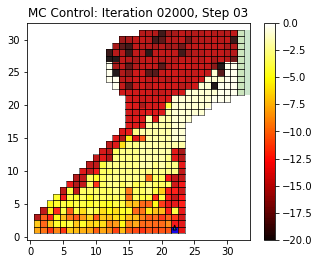

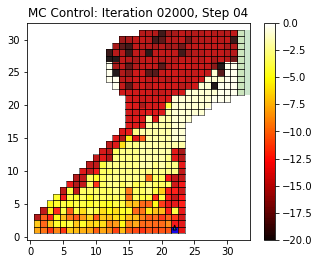

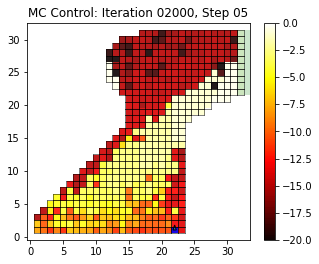

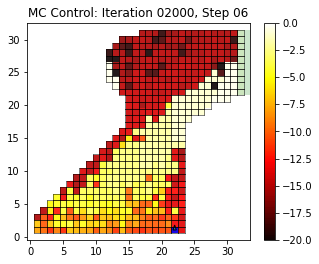

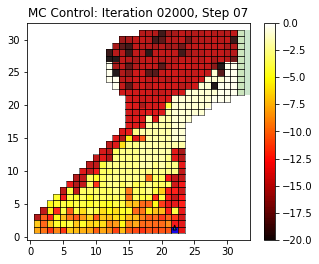

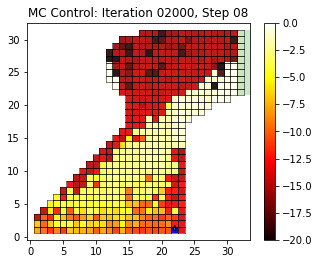

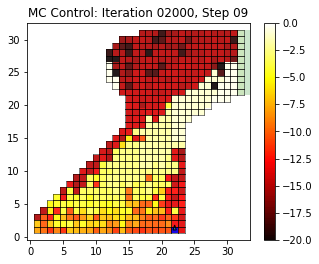

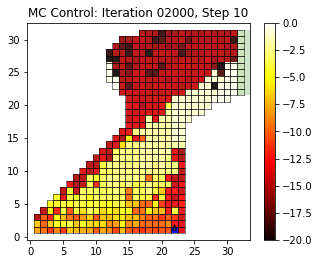

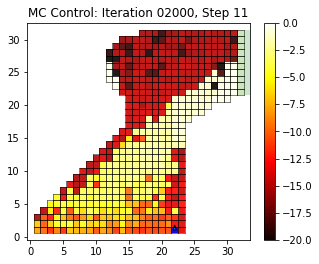

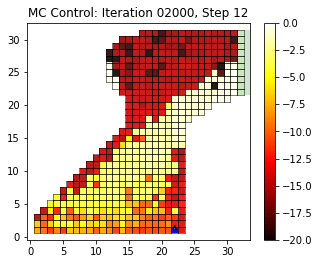

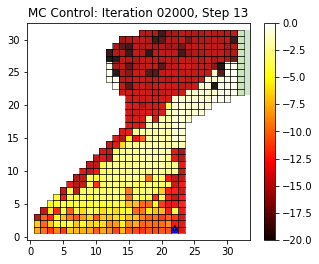

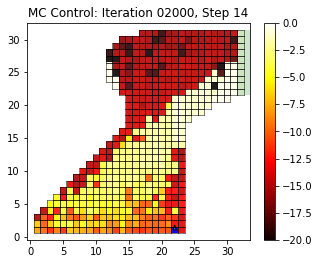

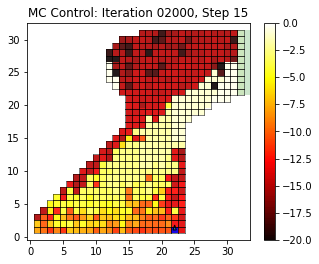

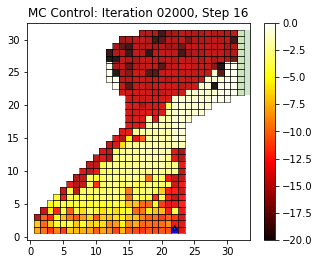

In [113]:
b_revised.plot_action_values(title=f'MC Control: Track B (Revised)')

In [ ]:
test_drive(TRACK_B, b_revised)

## Consider Slippage
Let's add the complexity of probabilistic state transitions by treating tire traction as non-deterministic. However our algorithm doesn't require a model for the environment and our approach is unchanged. Changes to our environment are fully captured in our episode generation process.

We expect Max to drive a bit more conservatively when losing control is a risk.

	Iteration 20000 of 100000...
	Iteration 40000 of 100000...
	Iteration 60000 of 100000...
	Iteration 80000 of 100000...


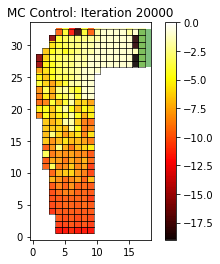

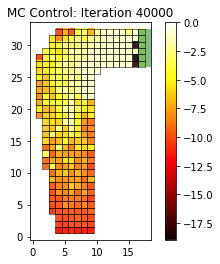

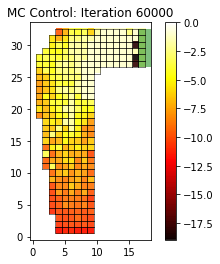

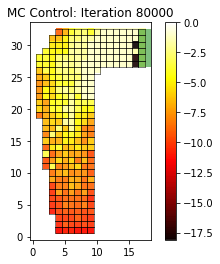

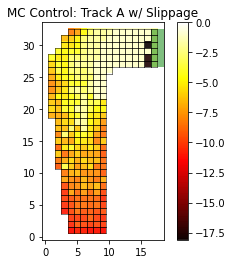

In [19]:
a_slippage = mc_control(DriveRevised(TRACK_A, slippage=0.1), iterations=int(1e5))
a_slippage.plot_action_values(title=f'MC Control: Track A w/ Slippage')

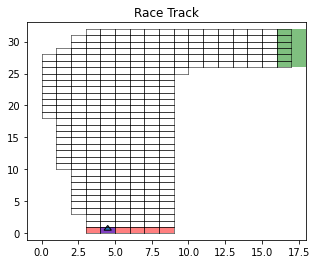

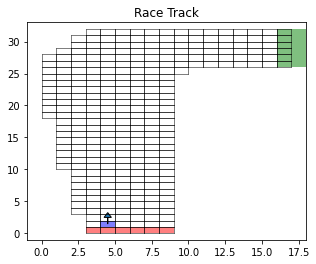

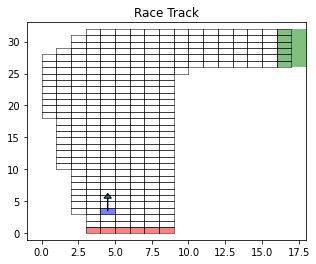

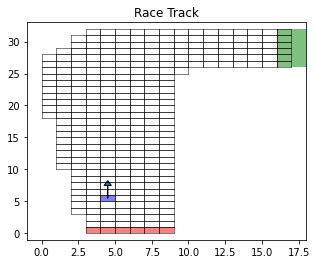

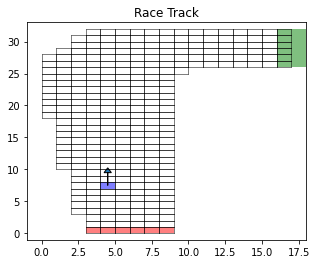

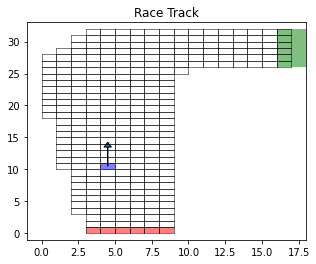

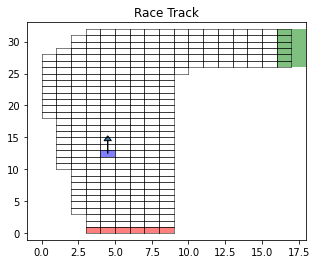

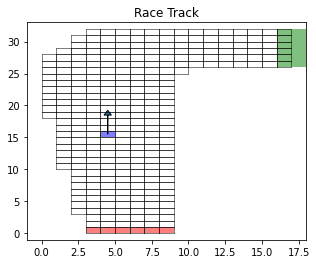

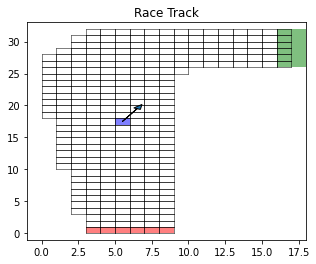

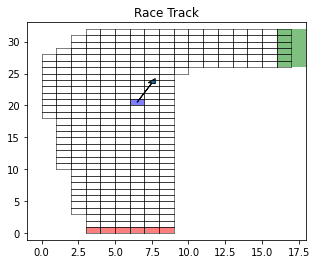

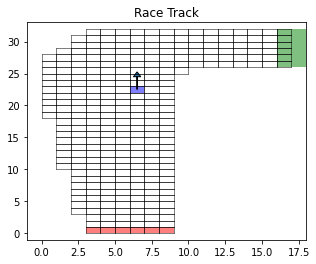

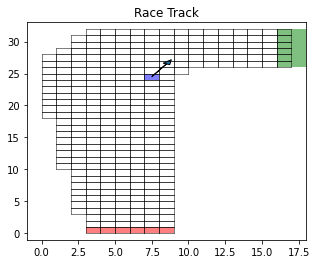

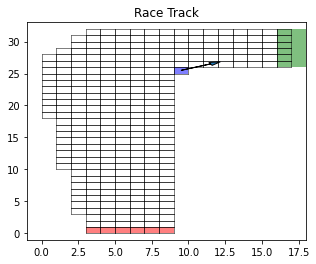

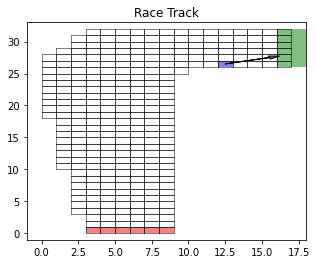

In [20]:
test_drive(TRACK_A, a_slippage)

	Iteration 20000 of 100000...
	Iteration 40000 of 100000...
	Iteration 60000 of 100000...
	Iteration 80000 of 100000...


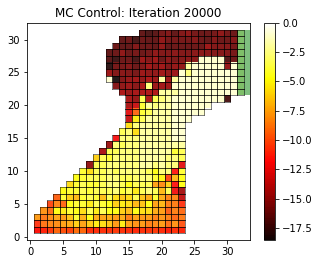

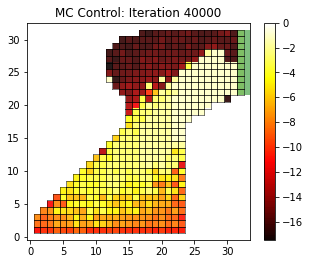

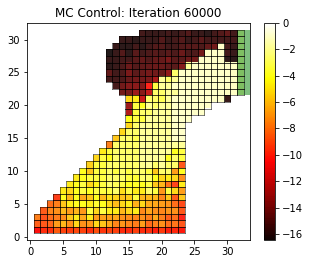

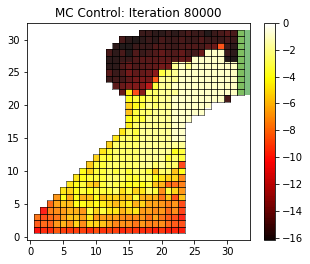

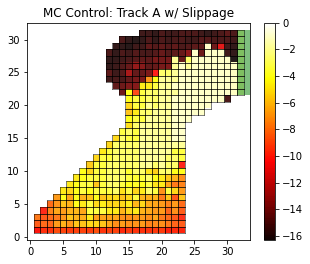

In [21]:
b_slippage = mc_control(DriveRevised(TRACK_B, slippage=0.1), iterations=int(1e5))
b_slippage.plot_action_values(title=f'MC Control: Track A w/ Slippage')

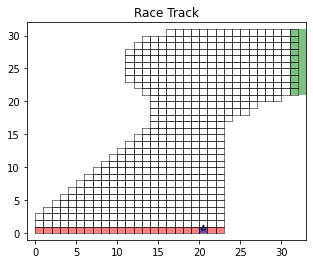

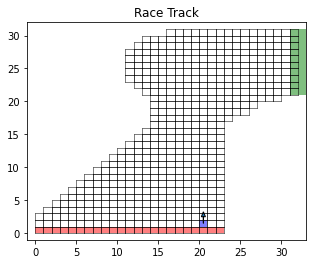

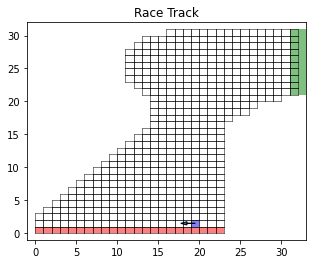

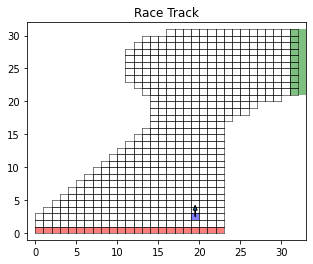

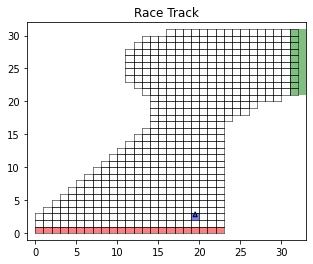

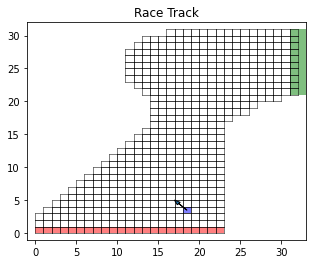

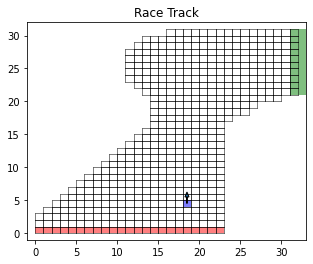

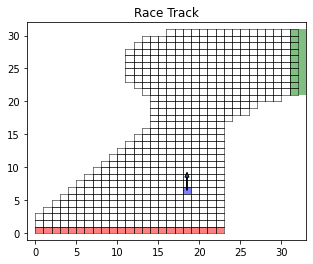

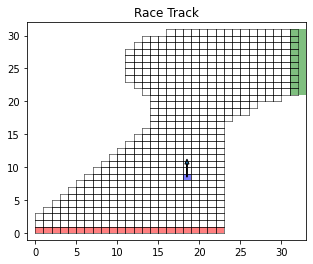

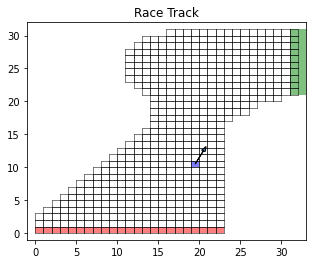

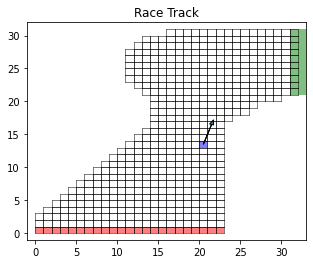

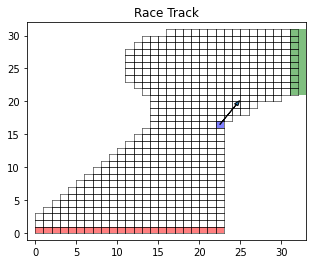

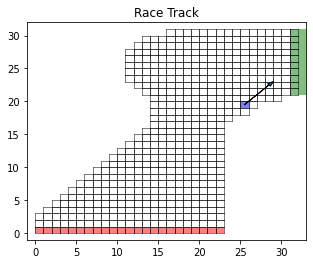

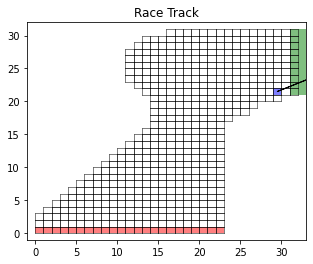

In [22]:
test_drive(TRACK_B, b_slippage)

## Temporal Difference Learning
Let's have Max update his actions throughout the turn, rather than waiting for until after he completes the turn.

In [23]:
def td_control(drive, alpha, every_visit=True, gamma=0.9, epsilon=0.1,
               T=int(1e5), iterations=int(1e4), log_frequency=None):
    if log_frequency is None:
        log_frequency = iterations // 5 if iterations > 10 else iterations + 1

    agent = Driver(drive.track, name='Max Verstappen', epsilon=epsilon)
    for i in range(1, iterations):
        if i % log_frequency == 0:
            print(f'\tIteration {i} of {iterations}...')
            agent.plot_action_values(title=f'MC Control: Iteration {i}')

        # Simulate episode from random (state, action)
        x0, y0 = random.choice(drive.track.starts)
        vx0, vy0 = (0, 0) 
        drive.set_state(DriverState(position=(x0, y0), velocity=(vx0, vy0)))
        
        s0 = (x0, y0, vx0, vy0)
        a0 = np.random.randint(0, 8)
        sa0 = (s0[0], s0[1], s0[2], s0[3], a0)
        
        steps = 0
        while steps < T:
            state, r1 = drive.transition(*Driver.itoa(a0))
            s1 = (state.position[0], state.position[1], state.velocity[0], state.velocity[1])
            if r1 >= 0:  # terminal state
                break
                
            a1 = agent.policy(s1)            
            sa1 = (s1[0], s1[1], s1[2], s1[3], a1)
            q0 = agent.action_values[sa0]
            q1 = agent.action_values[sa1]     
            
            # On-Policy update, mid-episode
            agent.action_values[sa0] = q0 + alpha * (r1 + gamma * q1 - q0)
            agent.update_state_policy((sa0[0], sa0[1], sa0[2], sa0[3]))
            
            # Prep the next timestep            
            a0 = a1
            sa0 = sa1              
            steps += 1       
    return agent

	Iteration 20000 of 100000...
	Iteration 40000 of 100000...
	Iteration 60000 of 100000...
	Iteration 80000 of 100000...


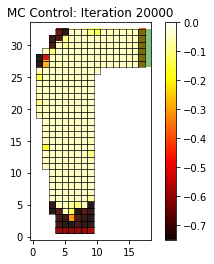

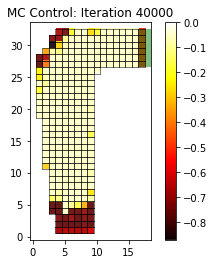

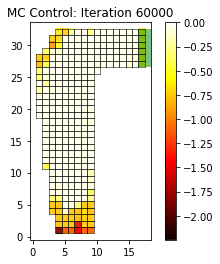

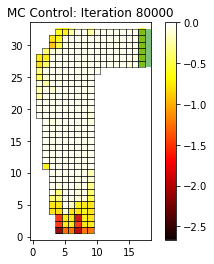

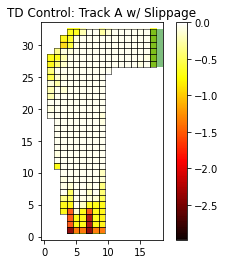

In [24]:
a_td = td_control(DriveRevised(TRACK_A, slippage=0.1), 0.05, iterations=int(1e5))
a_td.plot_action_values(title=f'TD Control: Track A w/ Slippage')

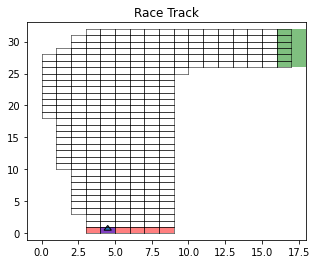

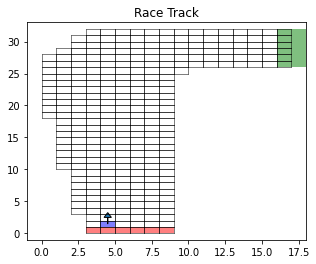

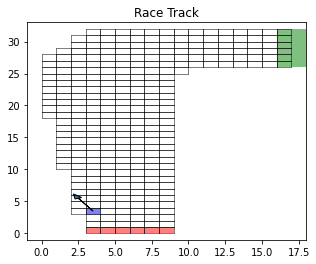

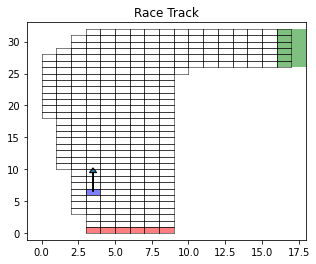

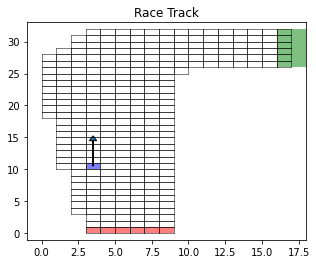

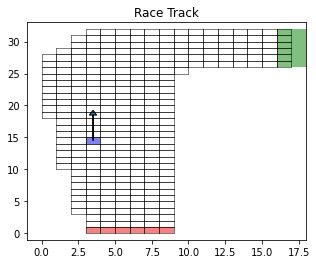

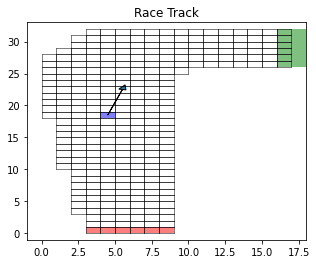

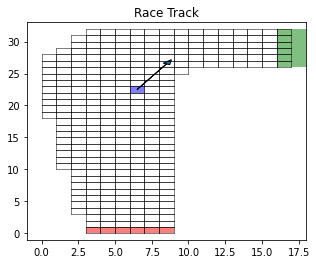

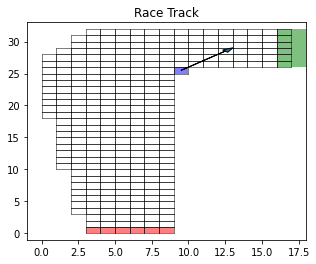

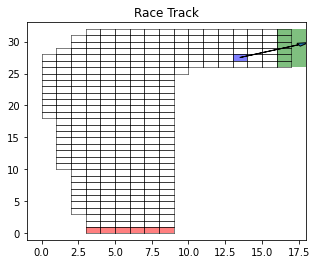

In [25]:
test_drive(TRACK_A, a_td)

	Iteration 20000 of 100000...
	Iteration 40000 of 100000...
	Iteration 60000 of 100000...
	Iteration 80000 of 100000...


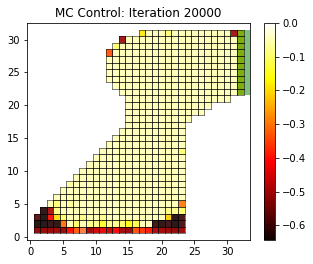

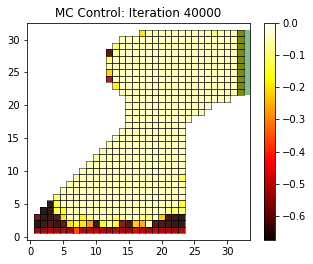

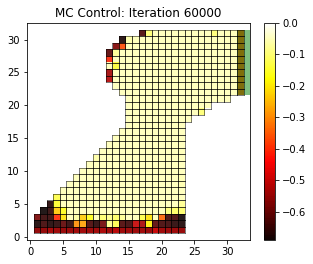

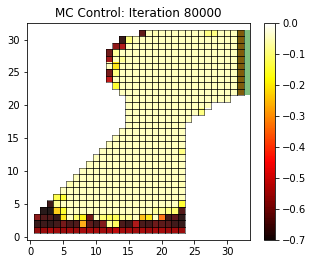

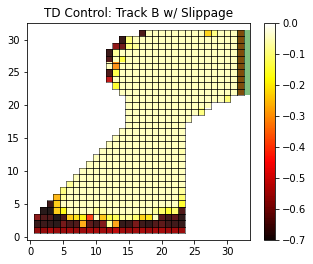

In [26]:
b_td = td_control(DriveRevised(TRACK_B, slippage=0.1), 0.05, iterations=int(1e5))
b_td.plot_action_values(title=f'TD Control: Track B w/ Slippage')

Max, that was embarassing.


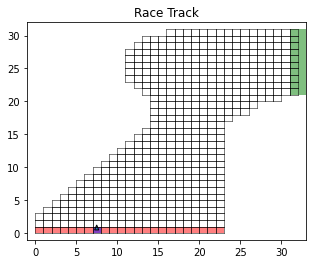

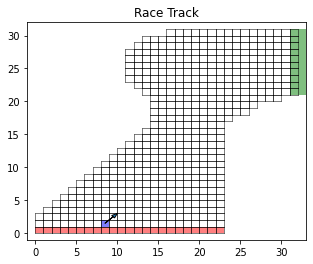

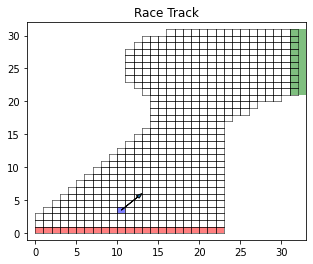

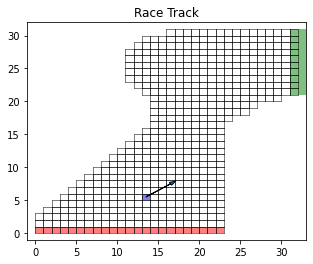

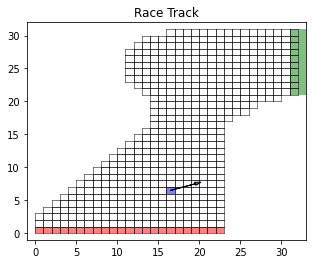

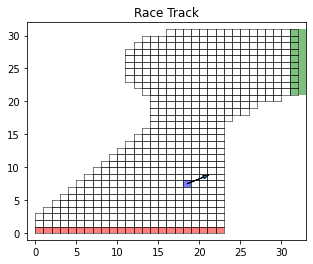

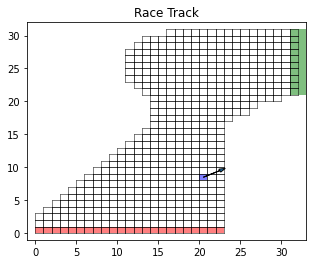

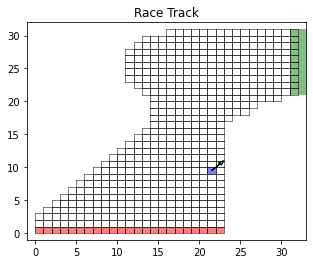

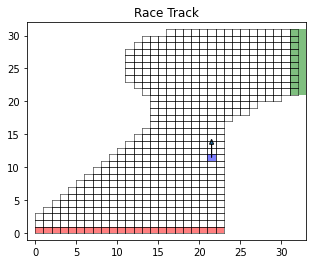

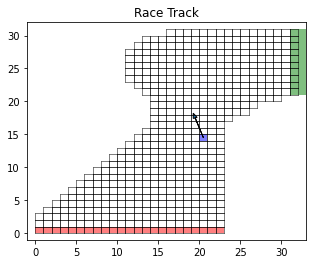

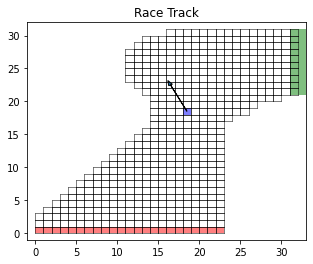

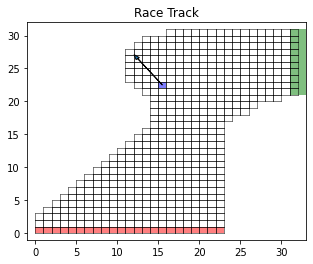

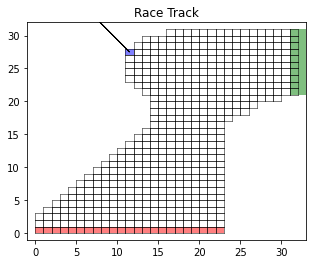

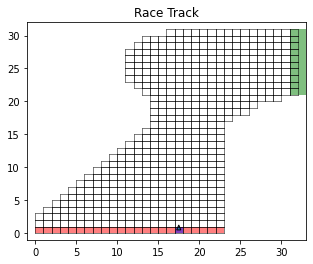

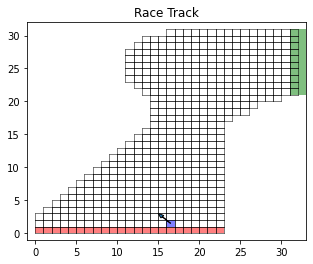

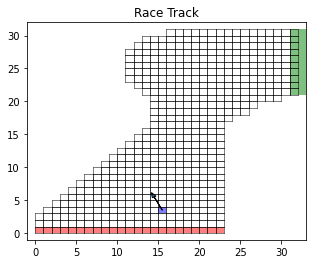

In [27]:
test_drive(TRACK_B, b_td)

## Discussion
Both these approaches solved our simple problem for both race tracks and for non-deterministic transitions by considering random tire slippage. TD-Learning (in this case, using the SARSA algorithm), provides a simpler framework creating updates while also enabling value improvements throughout the episode.

However, so far, we have constrained ourselves to the simple Gridworld environment where state-space and action-space are finite. We will need to explore new approaches, such as the Quadratic Linear Regulator (QLR) to tackle continuous problems with infinite actions.